In [1]:
from __future__ import print_function, division

import torch
import torch.optim as optim

from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import time
import os

import torch.nn as nn


class Net(nn.Module):
    """
    Input - 1x32x32
    Output - 10
    """
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, padding=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.2),

            nn.Flatten(), 
            nn.Linear(256*4*4, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax()
            )
        
    def forward(self, xb):
        return self.network(xb)

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0,0.1)),
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

    ]),
    'test': transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [3]:
data_dir = 'data' # Suppose the dataset is stored under this folder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']} # Read train and test sets, respectively.

train_dataloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=128,
                                             shuffle=True, num_workers=4)

test_dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=128,
                                             shuffle=False, num_workers=4)

train_size =len(image_datasets['train'])


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Set device to "cpu" if you have no gpu

In [4]:
def train_test(model, criterion, optimizer, scheduler, num_epochs=25):
    train_loss = []
    train_accuracy = []
    val_loss = [] 
    val_accuracy = []
    history = dict()
    model.train()
    for epoch in range(num_epochs):
        running_training_loss = 0.0
        running_training_accuracy = 0.0
        iteration_training_loss = 0.0
        total_training_predictions = 0
       
        start_time = time.time()
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_training_loss += loss.item()*inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total_training_predictions += labels.size(0)
            running_training_accuracy += (predicted == labels).sum().item()
            iteration_training_loss += loss.item() 
            if (i+1) % 100 == 0:
                print('Epoch:[%d]-Iteration:[%d], training loss: %.3f' %
                      (epoch + 1,i+1,iteration_training_loss/(i+1)))
        end_time = time.time()
        print('Time cost of one epoch: [%d]s' % (end_time-start_time))
        
        epoch_training_accuracy = running_training_accuracy / train_size*100
        epoch_training_loss = running_training_loss / train_size
        
        print('Epoch:[%d], training accuracy: %.1f, training loss: %.3f' %
              (epoch + 1,epoch_training_accuracy, epoch_training_loss))
        
        train_loss.append(epoch_training_loss)
        train_accuracy.append(epoch_training_accuracy)
        
        
        scheduler.step()
        
    print('Finished Training')

    history['train_loss'] = train_loss
    history['train_accuracy'] = train_accuracy

    correct = 0
    total = 0
    model.eval()
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on test images: %.3f %%' % (
            accuracy))
    return history, accuracy


In [5]:
from adabelief_pytorch import AdaBelief

if __name__ == '__main__':
    end = time.time()
    model_ft = Net().to(device) # Model initialization
    print(model_ft.network)
    criterion = nn.CrossEntropyLoss() # Loss function initialization

    # TODO: Adjust the following hyper-parameters: initial learning rate, decay strategy of the learning rate, number of training epochs
    optimizer_ft = AdaBelief(model_ft.parameters(), lr=0.0007) # The initial learning rate is 1e-3

    exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[15,20],gamma=0.6) # Decay strategy of the learning rate
    
    
    
    history, accuracy = train_test(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
               num_epochs=23) # The number of training epochs is 15
    
    print("time required %.2fs" %(time.time() - end))

Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.2, inplace=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.2, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=4096, out_features=128, bias=True)
  (14): ReLU()
  (15): Linear(in_features=128, out_features=10, bias=True)
  (16): Softmax(dim=None)
)
Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
----------

/Users/aditya/opt/miniconda3/envs/3314/lib/python3.8/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:[1]-Iteration:[100], training loss: 2.303
Epoch:[1]-Iteration:[200], training loss: 2.250
Time cost of one epoch: [101]s
Epoch:[1], training accuracy: 22.0, training loss: 2.215
Epoch:[2]-Iteration:[100], training loss: 1.931
Epoch:[2]-Iteration:[200], training loss: 1.909
Time cost of one epoch: [103]s
Epoch:[2], training accuracy: 56.4, training loss: 1.902
Epoch:[3]-Iteration:[100], training loss: 1.854
Epoch:[3]-Iteration:[200], training loss: 1.841
Time cost of one epoch: [100]s
Epoch:[3], training accuracy: 62.1, training loss: 1.841
Epoch:[4]-Iteration:[100], training loss: 1.822
Epoch:[4]-Iteration:[200], training loss: 1.815
Time cost of one epoch: [99]s
Epoch:[4], training accuracy: 64.8, training loss: 1.813
Epoch:[5]-Iteration:[100], training loss: 1.802
Epoch:[5]-Iteration:[200], training loss: 1.796
Time cost of one epoch: [101]s
Epoch:[5], training accuracy: 66.5, training loss: 1.796
Epoch:[6]-Iteration:[100], training loss: 1.790
Epoch:[6]-Iteration:[200], traini

In [7]:
print(accuracy)

91.2


In [6]:
history

{'train_loss': [2.2148407941818236,
  1.9017963310877481,
  1.8408709447860718,
  1.812884459622701,
  1.796442033958435,
  1.7826170234680176,
  1.7749646237691243,
  1.7466482411702473,
  1.7024567143758138,
  1.6931721232096355,
  1.6734854184468588,
  1.6254643599828085,
  1.6102226793289185,
  1.6061096956253051,
  1.6007804929733276,
  1.5823445859273275,
  1.5750779350280761,
  1.5722248675028483,
  1.569866742261251,
  1.5658084283828735,
  1.5574008693059285,
  1.5532288422266642,
  1.5506555880228678],
 'train_accuracy': [22.03,
  56.376666666666665,
  62.129999999999995,
  64.84,
  66.5,
  67.85666666666667,
  68.62,
  71.47666666666666,
  75.94333333333333,
  76.86333333333333,
  78.82666666666667,
  83.62666666666667,
  85.22666666666666,
  85.53333333333333,
  86.04666666666667,
  87.92333333333333,
  88.67,
  88.92999999999999,
  89.16333333333334,
  89.60333333333334,
  90.4,
  90.84666666666666,
  91.09333333333333]}

CNN Model Hyperparameters:
Learning Rate: 0.0007
Decay Strategy: Milestones - Counter({15: 1, 20: 1}), Gamma - 0.6
Epochs: 23


Text(0, 0.5, 'Accuracy')

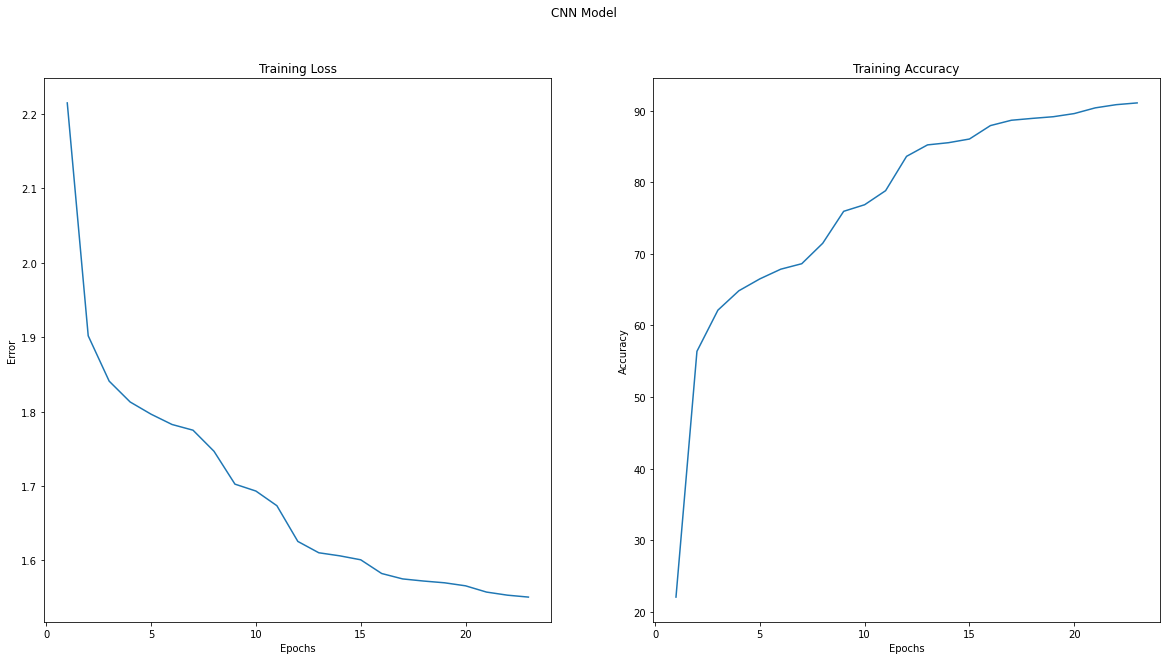

In [11]:
import matplotlib.pyplot as plt

print('CNN Model Hyperparameters:')
print('Learning Rate: ' + str(optimizer_ft.param_groups[0]['initial_lr']))
print(f'Decay Strategy: Milestones - {exp_lr_scheduler.milestones}, Gamma - {exp_lr_scheduler.gamma}')
print(f'Epochs: '+ str(len(history['train_loss'])))

fig, axs = plt.subplots(1,2, figsize = (20, 10))
fig.suptitle(f'CNN Model')

axs[0].plot(range(1,len(history['train_loss'])+1), history['train_loss'])
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Error')

axs[1].plot(range(1,len(history['train_accuracy'])+1), history['train_accuracy'])
axs[1].set_title('Training Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

In [12]:
import pandas as pd

class_accuracy = dict({})
class_total = [0 for i in range(10)]
class_correct = [0 for i in range(10)]
correct = 0
total = 0
model_ft.eval()
with torch.no_grad():
        for data in test_dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model_ft(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for c in range(10): #all classes
                class_total[c] += (labels==c).sum().item()
                class_correct[c] += ((predicted==labels)*(labels==c)).sum().item()
                if(class_total[c] != 0):
                    class_accuracy[c] = class_correct[c]/class_total[c] *100
                
accuracy = 100 * correct / total
print('Accuracy Statistics:\n')
print(f'Overall Accuracy: {accuracy}%')
df = pd.DataFrame(list(class_accuracy.items()), columns=['Class','Accuracy %'])
print(df.to_string(index=False))

Accuracy Statistics:

Overall Accuracy: 91.2%
 Class  Accuracy %
     0        92.6
     1        92.6
     2        92.8
     3        86.6
     4        95.6
     5        93.0
     6        89.0
     7        92.6
     8        87.4
     9        89.8
